# JigsawHSI for Hyper Spectral Image Classification

**Author:** Jaime MORAGA
**ORCID :** https://orcid.org/0000-0003-4483-9900

# Select dataset

In [1]:
## GLOBAL VARIABLES
dataset = 'IP_3d'
# dataset = 'IP_99.74'
# dataset = 'PU_100'
# dataset = 'SA_100'


# Initialize all random functions with same seed

In [2]:
import os
# Use this before loading tensorflow
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # Block INFO messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Block INFO and WARNING messages
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Block INFO, WARNING and ERROR messages
# https://www.tensorflow.org/api_docs/python/tf/autograph/set_verbosity
os.environ["AUTOGRAPH_VERBOSITY"] = "0"
import tensorflow as tf
tf.get_logger().setLevel("WARNING")

import random
import numpy as np

def random_seed():
    return os.urandom(42)

def reset_seeds(random_state = 42):
    try:
        tf.keras.utils.set_random_seed(random_state) # This resets all
        return 0
    except:
        random.seed(random_state)
        np.random.seed(random_state)
        tf.random.set_seed(random_state) # Tensorflow 2.9+
    try:
        from tensorflow import set_random_seed # Tensorflow 1.x
        set_random_seed(random_state)
        return 2
    except:
        pass
    return 1

max_gpus = len(tf.config.list_physical_devices('GPU'))

"""
Reset all random seeds
"""
r = reset_seeds(345)
del r

# Import libraries

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
 
from sklearn.decomposition import FactorAnalysis, NMF
from sklearn.decomposition import PCA, TruncatedSVD
from operator import truediv

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

#!pip install spectral
import spectral

# Define functions

## JigsawHSI definition

In [4]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Concatenate, Cropping2D # CenterCrop
from tensorflow.keras.layers import Conv2D, Conv3D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Reshape
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.regularizers import l2, l1, L1L2
from tensorflow.keras.optimizers import Adadelta, SGD, Adam, Nadam, Adagrad, Adamax

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import utils as np_utils

from skimage.transform import rotate
from tensorflow.keras.models import clone_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import multi_gpu_model

L2 = 0.001 # L2:0.002
act_reg = L1L2(l1=0.00001, l2=0.00001)# L1L2(l1=0.0001, l2=0.0001) # default (0.01, 0.01)

def jigsaw_m2( input_net, first_layer = None , internal_size = 13):
    # Creates internal filters as Inception: 1x1, 3x3, 5x5 ..., nxn 
    # Where n = internal_size
    jigsaw_t1_1x1 = Conv2D(64, (1,1), padding='same', activation = 'relu', 
                           kernel_regularizer = l2(L2),
                          activity_regularizer=act_reg)(input_net)
    jigsaw_t1_3x3_reduce = Conv2D(64, (1,1), padding='same', activation = 'relu', 
                                  kernel_regularizer = l2(L2),
                          activity_regularizer=act_reg)(input_net)
    jigsaw_t1_3x3 = Conv2D(64, (3,3), padding='same', 
                           activation = 'relu', 
                           kernel_regularizer = l2(L2),
                          activity_regularizer=act_reg)(jigsaw_t1_3x3_reduce) # , name="i_3x3"
    if (internal_size >= 5):
        jigsaw_t1_5x5_reduce = Conv2D(16, (1,1), padding='same', activation = 'relu', 
                                      kernel_regularizer = l2(L2),
                          activity_regularizer=act_reg)(input_net)
        jigsaw_t1_5x5 = Conv2D(16, (5,5), padding='same', activation = 'relu', 
                               kernel_regularizer = l2(L2),
                          activity_regularizer=act_reg)(jigsaw_t1_5x5_reduce) # , name="i_5x5"
    if (internal_size >= 7):
        jigsaw_t1_7x7_reduce = Conv2D(16, (1,1), padding='same', activation = 'relu', 
                                      kernel_regularizer = l2(L2),
                          activity_regularizer=act_reg)(input_net)
        jigsaw_t1_7x7 = Conv2D(16, (7,7), padding='same', activation = 'relu', 
                               kernel_regularizer = l2(L2),
                          activity_regularizer=act_reg)(jigsaw_t1_7x7_reduce) # , name="i_7x7"
    if (internal_size >= 9):
        jigsaw_t1_9x9_reduce = Conv2D(16, (1,1), padding='same', activation = 'relu', 
                                      kernel_regularizer = l2(L2),
                          activity_regularizer=act_reg)(input_net)
        jigsaw_t1_9x9 = Conv2D(16, (9,9), padding='same', activation = 'relu', 
                               kernel_regularizer = l2(L2),
                          activity_regularizer=act_reg)(jigsaw_t1_9x9_reduce) # , name="i_9x9"
    if (internal_size >= 11):
        jigsaw_t1_11x11_reduce = Conv2D(16, (1,1), padding='same', activation = 'relu', 
                                        kernel_regularizer = l2(L2),
                          activity_regularizer=act_reg)(input_net)
        jigsaw_t1_11x11 = Conv2D(16, (11,11), padding='same', activation = 'relu', 
                                 kernel_regularizer = l2(L2),
                          activity_regularizer=act_reg)(jigsaw_t1_11x11_reduce) # , name="i_11x11"
    if (internal_size >= 13):
        jigsaw_t1_13x13_reduce = Conv2D(16, (1,1), padding='same', activation = 'relu', 
                                        kernel_regularizer = l2(L2),
                          activity_regularizer=act_reg)(input_net)
        jigsaw_t1_13x13 = Conv2D(16, (13,13), padding='same', activation = 'relu', 
                                 kernel_regularizer = l2(L2),
                          activity_regularizer=act_reg)(jigsaw_t1_13x13_reduce) # , name="i_13x13"
    jigsaw_t1_pool = MaxPooling2D(pool_size=(3,3), strides = (1,1), padding='same')(input_net)
    jigsaw_t1_pool_proj = Conv2D(32, (1,1), padding='same', activation = 'relu', 
                                 kernel_regularizer = l2(L2),
                          activity_regularizer=act_reg)(jigsaw_t1_pool)
    jigsaw_list = [jigsaw_t1_1x1, jigsaw_t1_3x3]
    jigsaw_list = [jigsaw_t1_3x3]
    if (internal_size >= 5):
        jigsaw_list.append(jigsaw_t1_5x5)
    if (internal_size >= 7):
        jigsaw_list.append(jigsaw_t1_7x7)
    if (internal_size >= 9):
        jigsaw_list.append(jigsaw_t1_9x9)
    if (internal_size >= 11):
        jigsaw_list.append(jigsaw_t1_11x11)
    if (internal_size >= 13):
        jigsaw_list.append(jigsaw_t1_13x13)
    # Add MaxPooling results
    # jigsaw_list.append(jigsaw_t1_pool_proj)
    if first_layer is not None:
        jigsaw_t1_first = Conv2D(96, (1,1), padding='same', activation = 'relu', 
                                 kernel_regularizer = l2(L2),
                          activity_regularizer=act_reg)(first_layer)
        jigsaw_list.append(jigsaw_t1_first)
    if(len(jigsaw_list)>1):
        jigsaw_t1_output = Concatenate(axis = -1)(jigsaw_list)
    else:
        jigsaw_t1_output = jigsaw_list[0]
    return jigsaw_t1_output

def jigsaw_m_end(input_net, num_classes, first_layer = None):
    avg_pooling = AveragePooling2D(pool_size=(3,3), strides=(1,1), name='avg_pooling')(input_net)
    flat = Flatten()(avg_pooling)
    flat = Flatten()(input_net)
    flat = Dense(256, kernel_regularizer=l2(L2),
                          activity_regularizer=act_reg)(flat)
    flat = Dropout(0.4)(flat)
    if first_layer is not None:
        #jigsaw_center  = CenterCrop(height = 1, width = 1)(first_layer)
        fl_shape = first_layer.shape
        if (len(fl_shape)>4):
            first_layer = Reshape((fl_shape[1], fl_shape[2], fl_shape[3]*fl_shape[4]))(first_layer)
        
        fl_shape = first_layer.shape
        crop_1 = fl_shape[1]//2
        crop_2 = fl_shape[2]//2
        jigsaw_center  = Cropping2D( cropping = ((crop_1, crop_1), (crop_2, crop_2)))(first_layer)
        input_pixel = Flatten()(jigsaw_center)
        input_pixel = Dense(16, kernel_regularizer=l2(L2),
                          activity_regularizer=act_reg)(input_pixel)
        input_pixel = Dropout(0.4)(input_pixel)
        input_pixel = Dense(16, kernel_regularizer=l2(L2),
                          activity_regularizer=act_reg)(input_pixel)
        input_pixel = Dropout(0.4)(input_pixel)
        flat = Concatenate(axis = -1)([input_pixel, flat])
    flat = Dense(128, kernel_regularizer=l2(L2),
                          activity_regularizer=act_reg)(flat)
    dropout = Dropout(0.4)(flat)
    
    #loss3_classifier = Dense(num_classes, kernel_regularizer=l2(0.002))(dropout)
    #loss3_classifier_act = Activation('softmax', name='prob')(loss3_classifier)
    
    loss3_classifier_act = Dense(units=output_units, activation='softmax', name='Softmax')(dropout)
    
    return loss3_classifier_act


# Builds model
def build_jigsawHSI(internal_size=13, num_classes=2, image_dim = (19, 19, 7, 1), dimension_filters = None, verbose=1):
    my_input = Input( shape=image_dim )
    
    unit_norm = LayerNormalization(axis=2)(my_input)
    conv_layer1 = Conv3D(filters=64, kernel_size=(1, 1, 7), strides=(1, 1, 2), activation='relu', name='3d_1x1x7')(unit_norm)
    conv_layer2 = Conv3D(filters=32, kernel_size=(1, 1, 5), strides=(1, 1, 2), activation='relu', name='3d_1x1x5')(conv_layer1)
    conv_layer3    = Conv3D(filters=16, kernel_size=(1, 1, 3), strides=(1, 1, 2), activation='relu', name='3d_1x1x3')(conv_layer2)
    conv3d_shape = conv_layer3.shape
    
    if (len(conv3d_shape)>4):
        conv1 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
    else:
        conv1=conv_layer3
        
    # Not needed for SA
    if ((dimension_filters is None) or (dimension_filters < 1)):
        conv1 = conv1
    else:
        conv1 = Conv2D(dimension_filters, (1,1), padding='same', activation = 'relu',
                       kernel_regularizer = l2(L2), name='spectral_filter')(conv1)
    if(verbose>0):
        print(f"*** Building Jigsaw with up to {internal_size}x{internal_size} kernels")
    # One jigsaw module(s)
    jigsaw_01 = jigsaw_m2( my_input if conv1 is None else conv1, internal_size = internal_size )
    # For SA, the next two lines must be uncommented
    # jigsaw_01 = jigsaw_m2( jigsaw_01, first_layer=my_input, internal_size = internal_size )
    # jigsaw_01 = jigsaw_m2( jigsaw_01, internal_size = internal_size )
    
    # Attaches end to jigsaw modules, returns class within num_classes
    loss3_classifier_act = jigsaw_m_end(jigsaw_01,
                                    num_classes = num_classes, #) #,
                                    first_layer = my_input ) # testing num_classes
    model3 = Model( inputs = my_input, outputs = loss3_classifier_act, name = 'JigsawHSI' )
    model3.compile(loss='binary_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
    return model3


In [5]:
# Based on
# https://stackoverflow.com/questions/59563085/how-to-stop-training-when-it-hits-a-specific-validation-accuracy

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold, metric = "val_accuracy"):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold
        self.metric = metric

    def on_epoch_end(self, epoch, logs=None): 
        if (logs is None): return
        metric = logs[self.metric]
        if metric >= self.threshold:
            self.model.stop_training = True

## Decompostion functions: reduce dimensionality

In [6]:
# Dimensionality reduction algorithms
def applyPCA(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    pca = PCA(n_components=numComponents, whiten=True, random_state=random_state)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, 'pca'

def applyFA(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    fa = FactorAnalysis(n_components=numComponents, random_state=random_state)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, 'fa'

def applySVD(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    svd = TruncatedSVD(n_components=numComponents, random_state=random_state)
    newX = svd.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, 'svd'

def applyNMF(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    nmf = NMF(n_components=numComponents, random_state=random_state)
    newX = nmf.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, 'nmf'

def applyNone(X, numComponents=75, random_state=0):
    return X, 'None'


## Utilitary functions

In [7]:
def readData(dataset, data_path='./data'):
    data_dict = {
        'IP': ('Indian_pines_corrected.mat', 'indian_pines_corrected', 'Indian_pines_gt.mat', 'indian_pines_gt'),
        'SA': ('Salinas_corrected.mat', 'salinas_corrected', 'Salinas_gt.mat', 'salinas_gt'),
        'PU': ('PaviaU.mat', 'paviaU', 'PaviaU_gt.mat', 'paviaU_gt')
    }
    (X_1, X_2, y_1, y_2) = data_dict.get(dataset[0:2].upper())
    X = sio.loadmat(os.path.join(data_path, X_1))[X_2]
    y = sio.loadmat(os.path.join(data_path, y_1))[y_2]
    
    return (X, y)


In [8]:
def splitTrainTestSet(X, y, testRatio, random_state=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=random_state,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test


In [9]:
# Padding functions
def padWithZeros(X, margin=2):
    newX = np.pad(X, pad_width=((margin, margin),(margin, margin),(0, 0)), constant_values = 0, mode = 'constant')
    return newX

def padSymmetric(X, margin=2):
    newX = np.pad(X, pad_width=((margin, margin),(margin, margin),(0, 0)), mode = 'symmetric')
    return newX




In [10]:
def createImageCubes(X, y, window_size=8, removeZeroLabels = True):
    margin = int((window_size-1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], window_size, window_size, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1 , c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

# Load parameters from config file (config.ini)

In [11]:
import configparser
config = configparser.ConfigParser(inline_comment_prefixes=';#')
config.read_file(open('config.ini'))
config = config[dataset]

In [12]:
# Parse parameters and hyper-parameters from config file

test_ratio   = config.getfloat('test_ratio', 0.9)
window_size  = config.getint('window_size', 25)
num_channels = config.getint('num_channels', 3)
output_units = config.getint('output_units', 16)

filter_size  = config.getint('filter_size', 13)

batch_size   = config.getint('batch_size', 30)
max_epochs   = config.getint('max_epochs', 100)

decomp_func  = config.get('decomp_func', 'pca').lower()
optimizer_fn = config.get('optimizer_fn', 'sgd').lower()
optimizer_lr = config.getfloat('optimizer_lr', 0.01)
max_patience = config.getint('max_patience', 10)

hsi_filters  = config.get('hsi_filters', 'none')
hsi_filters  = None if (hsi_filters.lower() in ['none', '']) else int(hsi_filters)
print(hsi_filters)

None


## Select proper optimizer and decomposition functions

In [13]:
dict_reduction={
    'fa' : applyFA,
    'nmf' : applyNMF,
    'pca': applyPCA,
    'svd': applySVD,
    'none': applyNone
}

DimReduction=dict_reduction.get(decomp_func)

dict_optimizer = {
    'sgd'     : SGD(learning_rate=optimizer_lr, momentum=0.9, nesterov=False),
    'adadelta': Adadelta(learning_rate=optimizer_lr, rho=0.95, epsilon=1e-07),
    'adam'    : Adam(learning_rate=optimizer_lr, epsilon=1e-07, decay=1e-06),
    'nadam'   : Nadam(learning_rate=optimizer_lr, epsilon=1e-07),
    'adamax'  : Adamax(learning_rate=optimizer_lr, epsilon=1e-07),
    'adagrad' : Adagrad(learning_rate=optimizer_lr, epsilon=1e-07)
}

FuncOptimizer = dict_optimizer.get(optimizer_fn)

In [14]:
# Define names of output files
best_model          = dataset + '-best-model.hdf5'
last_model          = dataset + '-last-model.hdf5'
loss_curve          = dataset + '-loss-curve.png'
acc_curve           = dataset + '-acc-curve.png'
classification_file = dataset + '-classification_report.txt'
predictions_img     = dataset + '-predictions.png'
architecture_img    = dataset + '-architecture.png'

In [15]:
HSI, HSI_y = readData(dataset[0:2].upper())

HSI.shape, HSI_y.shape

((145, 145, 200), (145, 145))

In [16]:
num_channels = np.min([HSI.shape[2], num_channels])

In [17]:
DRI, dim_reduction = DimReduction(HSI,numComponents=num_channels)

num_channels = DRI.shape[2]
DRI.shape

(145, 145, 200)

In [18]:
X, y = createImageCubes(DRI, HSI_y, window_size=window_size)
X = X.reshape(-1, window_size, window_size, num_channels, 1)

X.shape, y.shape

((10249, 27, 27, 200, 1), (10249,))

In [19]:
print("Splitting training set")
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)
print("Splitting validation and testing sets")
Xvalidate, Xtest, yvalidate, ytest = splitTrainTestSet(Xtest, ytest, 0.7, random_state=None)
# Xvalidate, _, yvalidate, _ = splitTrainTestSet(X, y, 0.5, random_state=None)

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
print(Xvalidate.shape, yvalidate.shape)

Splitting training set
Splitting validation and testing sets
(3074, 27, 27, 200, 1) (5023, 27, 27, 200, 1) (3074,) (5023,)
(2152, 27, 27, 200, 1) (2152,)


In [20]:
from sklearn.utils import class_weight
sample_weights = class_weight.compute_sample_weight(class_weight = 'balanced', y = ytrain)
#print(sample_weights[:20])
#sample_weight_dict = dict(enumerate(sample_weight))
#print(sample_weight_dict)

In [21]:
ytrain = np_utils.to_categorical(ytrain)
yvalidate = np_utils.to_categorical(yvalidate)
ytrain.shape, yvalidate.shape

((3074, 16), (2152, 16))

In [22]:
input_shape =  (window_size, window_size, num_channels, 1)

# Build network

In [23]:

input_shape =  (window_size, window_size, num_channels, 1) #, 1)
print(input_shape)
model = clone_model(build_jigsawHSI(internal_size = filter_size,
                      num_classes = output_units,
                      verbose=1,
                      dimension_filters=hsi_filters, # Was None,
                      image_dim = input_shape))



(27, 27, 200, 1)
*** Building Jigsaw with up to 9x9 kernels


Model: "JigsawHSI"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27, 27, 200, 0                                            
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 27, 27, 200,  54          input_1[0][0]                    
__________________________________________________________________________________________________
3d_1x1x7 (Conv3D)               (None, 27, 27, 97, 6 512         layer_normalization[0][0]        
__________________________________________________________________________________________________
3d_1x1x5 (Conv3D)               (None, 27, 27, 47, 3 10272       3d_1x1x7[0][0]                   
__________________________________________________________________________________________

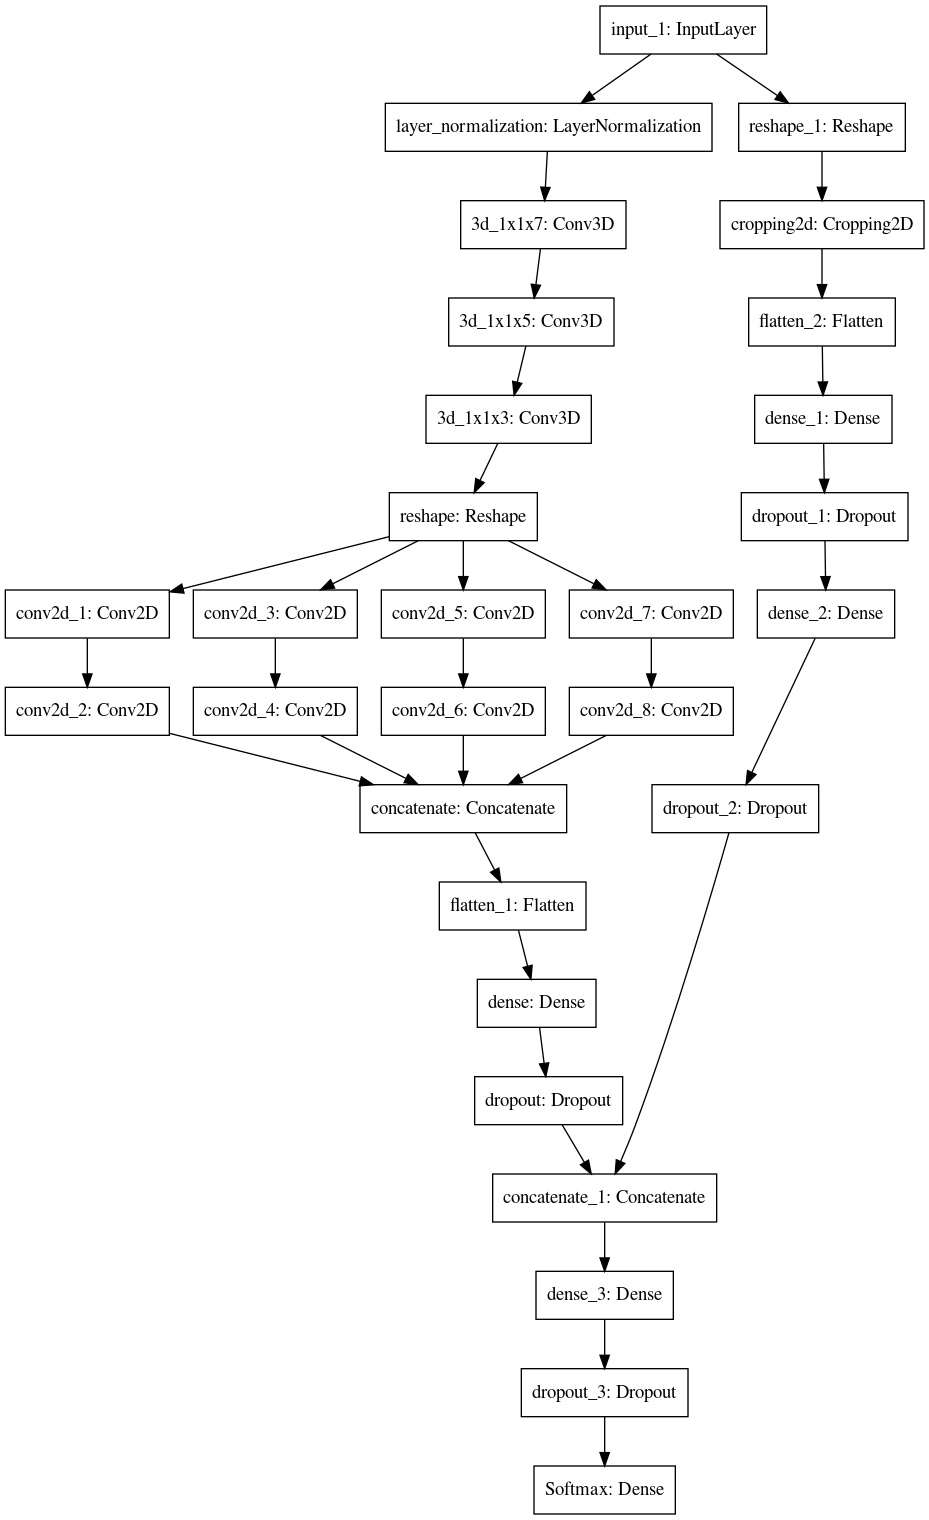

In [24]:
model.summary()
plot_model(model)
plot_model(model, to_file=architecture_img)

In [25]:
# Parallelize if gpus > 1
if (max_gpus>1):
    model = multi_gpu_model(model, gpus=max_gpus)
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=FuncOptimizer, metrics=['accuracy'])

# Callback functions: EarlyStop and ModelCheckpoint

In [26]:
# Saves the best model, based on accuracy
checkpoint = ModelCheckpoint(best_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
checkpoint2 = ModelCheckpoint(last_model, monitor='accuracy', verbose=1, save_best_only=False, mode='auto', save_freq='epoch')
callbacks_list = [checkpoint, checkpoint2]

In [27]:
# If no early stopping desired, skip this cell

early_stop = EarlyStopping( monitor = 'val_loss',
                           min_delta=0.001,
                           mode='auto',
                           verbose=1, patience=max_patience)
early_stop2 = MyThresholdCallback(threshold=0.99999)

callbacks_list = [checkpoint, checkpoint2, early_stop, early_stop2]


In [28]:
# Summarize configuration
config_txt  = f'Configuration for dataset [{dataset}]:\n\n'
config_txt += f'Test Set Ratio: {test_ratio*100}% of samples\n'
config_txt += f'Window Size   : {window_size} pixels per side\n'
config_txt += f'Dim. Reduction: {dim_reduction} function\n'
config_txt += f'Num channels  : {num_channels} bands after {dim_reduction}\n'
config_txt += '# Network design\n'
config_txt += f'Input shape   : ({window_size}x{window_size}x{num_channels})\n'
config_txt += f'HSI Filters   : {hsi_filters} filters in first layer\n'
config_txt += f'Internal Size : ({filter_size}x{filter_size}) maximum network filter size\n'
config_txt += '# Training hyperparameters\n'
config_txt += f'Optimizer     : {optimizer_fn}\n'
config_txt += f'Learning rate : {optimizer_lr}\n'
config_txt += f'Batch Size    : {batch_size}\n'
config_txt += f'Num Epochs    : {max_epochs}\n' 
config_txt += f'Patience      : {max_patience}\n'
config_txt += '# Training GPUs\n'
config_txt += f'GPU Maximum   : {max_gpus}\n'
print(config_txt)

Configuration for dataset [IP_3d]:

Test Set Ratio: 70.0% of samples
Window Size   : 27 pixels per side
Dim. Reduction: None function
Num channels  : 200 bands after None
# Network design
Input shape   : (27x27x200)
HSI Filters   : None filters in first layer
Internal Size : (9x9) maximum network filter size
# Training hyperparameters
Optimizer     : adadelta
Learning rate : 0.1
Batch Size    : 20
Num Epochs    : 300
Patience      : 10
# Training GPUs
GPU Maximum   : 1



# Spatial Cross-validation (SKIP IF NOT DOING Spatial Cross-validation)

In [29]:
from jigsaw.imagespcv import ImageSpCV
from sklearn.utils import class_weight

do_SpCv = False
if (do_SpCv):
    iSpCV = ImageSpCV(DRI, HSI_y, kernel_size = window_size, num_channels = num_channels,
                          sample = None, verbose = 1, # padding_mode='symmetric',
                      partitions=5,
                          augment=False, random_state=42)
    #cv = iSpCV.SpatialCV()
    cv = iSpCV.RepeatedSpCV(2)
    X  = iSpCV.X()
    X  = X[np.arange(len(X))] # Generate all windows, to make them static
    y  = iSpCV.y()-1
    # y_cat = to_categorical(y)
    for i, (train, test) in enumerate(cv):
        pass
    print(f'###### Running Fold {(i+1):03d} ######')
    train_X = X[train]
    Xtrain = train_X.reshape(-1, window_size, window_size, num_channels) #, 1)

    train_y = y[train]


    sample_weights = class_weight.compute_sample_weight(class_weight = 'balanced', y = train_y)

    num_unique_y = np.unique(train_y)
    if (len(num_unique_y) < len(np.unique(y))):
        print("### Not enough samples from each class")
        pass
    ytrain = np_utils.to_categorical(train_y, num_classes = output_units)

    print(f'> Training shapes: {Xtrain.shape, ytrain.shape}')

    # Start validation routines
    test_X = X[test]
    Xtest = test_X.reshape(-1, window_size, window_size, num_channels, 1)
    ytest = y[test]

    Xvalidate, Xtest, yvalidate, ytest = splitTrainTestSet(Xtest, ytest, 0.5, random_state=None)

    Xvalidate = Xvalidate.reshape(-1, window_size, window_size, num_channels, 1)

    yvalidate = np_utils.to_categorical(yvalidate, num_classes = output_units)
    print(f'> Validation shapes: {Xvalidate.shape, yvalidate.shape}')

ModuleNotFoundError: No module named 'jigsaw'

In [30]:
from jigsaw.datagen import DataGenerator

input_shape =  (window_size, window_size, num_channels, 1)  # , 1)

params = {'dim':input_shape, 'batch_size': batch_size,
        'n_classes': output_units,
        'n_channels': num_channels,
        'shuffle': False, 'augment_data': False}
Xtrain=Xtrain.squeeze()
print(f'Xtrain shape: {Xtrain.shape}')
my_batch_gen = DataGenerator(Xtrain, ytrain, **params)
#Xtrain = train_X.reshape(-1, window_size, window_size, num_channels, 1)
#Xtrain = Xtrain.reshape(-1, window_size, window_size, num_channels, 1)

ModuleNotFoundError: No module named 'jigsaw'

In [31]:
a = Xtrain[0]
print(a.shape)
b = np.squeeze(a)
print(b.shape)

(27, 27, 200, 1)
(27, 27, 200)


# Fit the model

In [32]:
import gc
del X, y
gc.collect()

993

In [33]:
# load last saved model weights
if (os.path.exists(last_model)):
    model.load_weights(last_model)
    model.compile(loss='categorical_crossentropy', optimizer=FuncOptimizer, metrics=['accuracy'])

# Fit the model keeping the history
history = model.fit(x=Xtrain, y=ytrain, 
#history = model.fit(my_batch_gen, 
                    validation_data = (Xvalidate, yvalidate),
                    batch_size=batch_size, epochs=1, 
                    sample_weight = sample_weights,
                    callbacks=callbacks_list)

154/154 [==============================] - ETA: 0s - loss: 4673.2915 - accuracy: 0.0787
Epoch 00001: val_accuracy improved from -inf to 0.11245, saving model to IP_3d-best-model.hdf5

Epoch 00001: saving model to IP_3d-last-model.hdf5
154/154 [==============================] - 34s 219ms/step - loss: 4673.2915 - accuracy: 0.0787 - val_loss: 398.4794 - val_accuracy: 0.1125


In [34]:
# model.save(best_model)

# Validation

In [35]:
# Saves, but does not display, the history charts
fig = plt.figure(figsize=(7,7)) 
plt.ioff()
plt.grid() 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig(loss_curve) 
plt.close(fig)

fig = plt.figure(figsize=(7,7)) 
plt.ioff()
plt.ylim(np.min(history.history['accuracy']),1.05) 
plt.grid() 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig(acc_curve) 
plt.close(fig) 

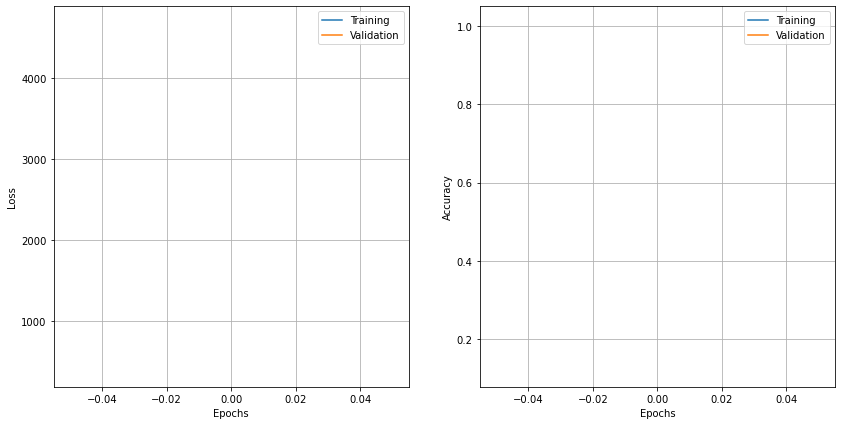

In [36]:
# Displays history of training
# loss and accuracy by epoch, side by side

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 7))
ax1.grid() 
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_ylabel('Loss') 
ax1.set_xlabel('Epochs') 
ax1.legend(['Training','Validation'], loc='upper right') 

ax2.set_ylim(np.min(np.append(history.history['accuracy'], history.history['val_accuracy'])),1.05) 
ax2.grid() 
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_ylabel('Accuracy') 
ax2.set_xlabel('Epochs') 
ax2.legend(['Training','Validation']) 
plt.show() # plt.tight_layout()

In [37]:
# load best weights
model.load_weights(best_model)
model.compile(loss='categorical_crossentropy', optimizer=FuncOptimizer, metrics=['accuracy'])

In [38]:
Xtest = Xtest.reshape(-1, window_size, window_size, num_channels, 1)
Xtest.shape

(5023, 27, 27, 200, 1)

In [39]:
Ytest = np_utils.to_categorical(ytest, num_classes = output_units)
Ytest.shape

(5023, 16)

In [40]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)


In [41]:
print(y_pred_test.shape) 
classification = classification_report(np.argmax(Ytest, axis=1), y_pred_test)
print(classification)

(5023,)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.02      0.01      0.01       700
           2       0.00      0.00      0.00       407
           3       0.00      0.00      0.00       116
           4       0.00      0.00      0.00       237
           5       0.19      0.33      0.24       358
           6       0.00      0.00      0.00        14
           7       0.31      0.18      0.23       235
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00       476
          10       0.24      0.09      0.13      1203
          11       0.06      0.35      0.10       291
          12       0.02      0.12      0.04       100
          13       0.38      0.24      0.30       620
          14       0.00      0.00      0.00       189
          15       0.00      0.00      0.00        45

    accuracy                           0.11      5023
   macro avg      

/home/dpate2771/.conda/envs/cenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dpate2771/.conda/envs/cenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dpate2771/.conda/envs/cenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_row_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_row_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [43]:
def get_targets(name):
    targets_dict = {
        'IP': ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
               'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill', 'Soybean-clean', 'Wheat', 'Woods', 
               'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers'],
        'SA': ['Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow', 'Fallow_smooth', 'Stubble',
               'Celery','Grapes_untrained', 'Soil_vinyard_develop', 'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk',
               'Lettuce_romaine_5wk', 'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained',
               'Vinyard_vertical_trellis'],
        'PU': ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks',
               'Shadows']
    }
    targets = targets_dict.get(name)
    return (targets)


print(', '.join(get_targets(dataset[0:2].upper())))

def reports (model, X_test, y_test, name, y_pred = None):
    #start = time.time()
    if (y_pred is None):
        Y_pred = model.predict(X_test)
        y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    target_names = get_targets(name[0:2].upper())
    print("Producing report")
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    #score = model.evaluate(X_test, y_test, batch_size=32)
    #Test_Loss =  score[0]*100
    #Test_accuracy = score[1]*100
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100, target_names

Alfalfa, Corn-notill, Corn-mintill, Corn, Grass-pasture, Grass-trees, Grass-pasture-mowed, Hay-windrowed, Oats, Soybean-notill, Soybean-mintill, Soybean-clean, Wheat, Woods, Buildings-Grass-Trees-Drives, Stone-Steel-Towers


In [49]:
(classification, confusion, 
 oa, each_acc, aa, kappa, target_names) = reports(model, Xtest, Ytest, dataset[0:2], y_pred=y_pred_test)

Producing report


/home/dpate2771/.conda/envs/cenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dpate2771/.conda/envs/cenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dpate2771/.conda/envs/cenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
target_performance = 'Recall by target:\n'
for (a, b) in zip(target_names, each_acc):
    target_performance += f'{b:8.4f} : {a}\n'
print(target_performance)

Recall by target:
  0.0000 : Alfalfa
  0.5714 : Corn-notill
  0.0000 : Corn-mintill
  0.0000 : Corn
  0.4219 : Grass-pasture
 33.2402 : Grass-trees
  0.0000 : Grass-pasture-mowed
 18.2979 : Hay-windrowed
  0.0000 : Oats
  0.0000 : Soybean-notill
  8.9776 : Soybean-mintill
 34.7079 : Soybean-clean
 12.0000 : Wheat
 24.1935 : Woods
  0.0000 : Buildings-Grass-Trees-Drives
  0.0000 : Stone-Steel-Towers



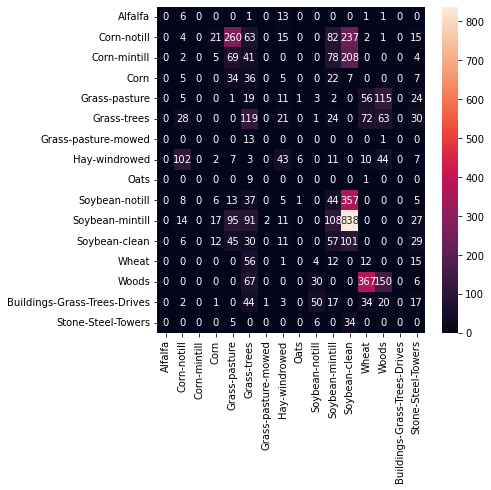

In [51]:
import seaborn as sns
cf_matrix = np.asarray(confusion)
plt.figure(figsize=(6,6))
sns_plot=sns.heatmap(cf_matrix, annot=True, xticklabels=target_names, yticklabels=target_names, fmt='1d')
#sns_plot.figure.savefig(str(dataset)+'-heatmap.png', dpi=300)
plt.savefig(str(dataset)+'-heatmap.png', bbox_inches='tight', dpi=300)

In [52]:
classification = str(classification)
confusion = str(confusion)
confusion=confusion.replace('\n', '')
confusion=confusion.replace('] [', ']\n[')
confusion=confusion.replace('][', ']\n[')
confusion=confusion.replace('[[', '[')
confusion=confusion.replace(']]', ']')
# dim_reduction='pca'
c_summary = 'Classification Summary\n'
#c_summary += f'{Test_loss:7.3f} Test loss (%)\n'
#c_summary += f'{Test_accuracy:7.3f} Test accuracy (%)\n'
c_summary += f'{kappa:7.3f} Kappa accuracy (%)\n'
c_summary += f'{oa:7.3f} Overall accuracy (%)\n'
c_summary += f'{aa:7.3f} Average accuracy (%)\n\n'

c_summary += f'{classification}\n\n'
c_summary += f'{confusion}\n\n'

model_summary = []
model.summary(print_fn=lambda x: model_summary.append(x)) # line_length=70,
model_summary = '\n'.join(model_summary)
model_summary += '\n\n'

print(c_summary)
print(target_performance+'\n\n')
print(model_summary)
print(config_txt)

with open(classification_file, 'w') as cs_file:
    cs_file.write(c_summary)
    cs_file.write(target_performance+'\n\n')
    cs_file.write(model_summary)
    cs_file.write(config_txt)

Classification Summary
  3.273 Kappa accuracy (%)
 10.711 Overall accuracy (%)
  8.276 Average accuracy (%)

                              precision    recall  f1-score   support

                     Alfalfa       0.00      0.00      0.00        22
                 Corn-notill       0.02      0.01      0.01       700
                Corn-mintill       0.00      0.00      0.00       407
                        Corn       0.00      0.00      0.00       116
               Grass-pasture       0.00      0.00      0.00       237
                 Grass-trees       0.19      0.33      0.24       358
         Grass-pasture-mowed       0.00      0.00      0.00        14
               Hay-windrowed       0.31      0.18      0.23       235
                        Oats       0.00      0.00      0.00        10
              Soybean-notill       0.00      0.00      0.00       476
             Soybean-mintill       0.24      0.09      0.13      1203
               Soybean-clean       0.06      0.35 

In [53]:
def Patch(data, height_index, width_index, PATCH_SIZE):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [54]:
height = HSI_y.shape[0]
width  = HSI_y.shape[1]

In [55]:
X = padWithZeros(DRI, window_size//2)

In [56]:
X.shape

(171, 171, 200)

In [57]:
from tqdm import tqdm
# calculate the predicted image
outputs = np.zeros((height,width))
#for i in range(height):
for i in tqdm(range(height), desc="Predicting...",
                          ascii=False, ncols=75):
    for j in range(width):
        target = int(HSI_y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X, i, j, window_size)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2]).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1


Predicting...: 100%|█████████████████████| 145/145 [02:45<00:00,  1.14s/it]


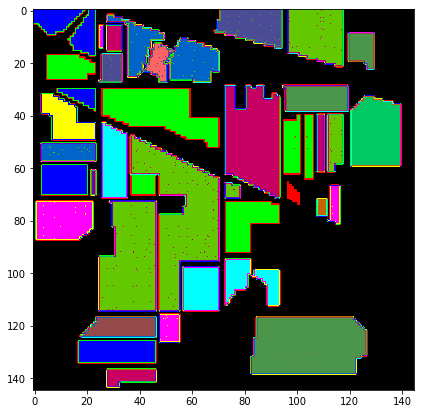

In [58]:
ground_truth = spectral.imshow(classes = HSI_y,figsize =(7,7))

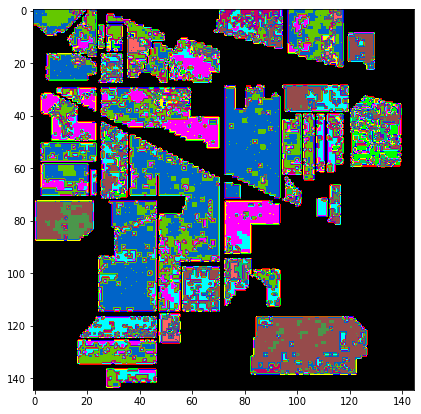

In [59]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

Misclassified pixels:  9118 / 21025


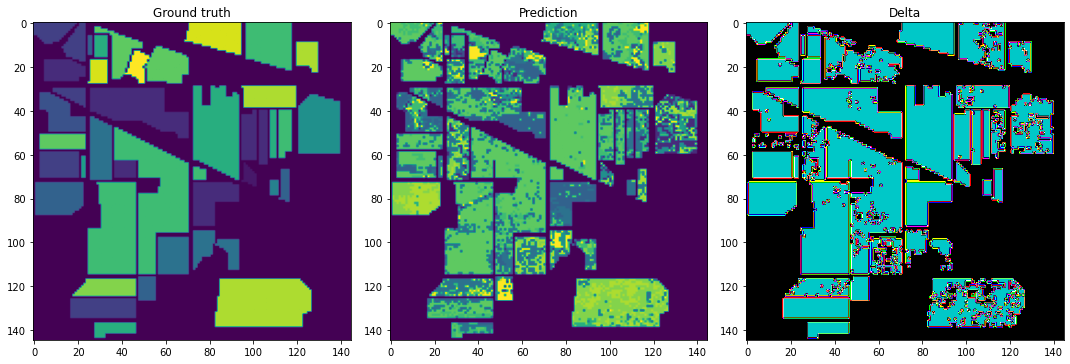

In [60]:
from matplotlib.colors import ListedColormap, NoNorm

cm = ListedColormap(np.array(spectral.spy_colors)/255.0)
delta = (np.abs(outputs.astype(int) - (HSI_y))>0)*1
print('Misclassified pixels: ', np.sum(np.asarray(delta)>0), "/", delta.shape[0]*delta.shape[1])
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,8))
ax1.set_title("Ground truth")
ax2.set_title("Prediction")
ax3.set_title("Delta")
ax1.imshow(HSI_y) #, cmap=cm, norm=NoNorm())
ax2.imshow(outputs.astype(int)) #, cmap=cm, norm=NoNorm())
ax3.imshow(delta, cmap=cm)
plt.tight_layout()

In [61]:
spectral.save_rgb(str(dataset)+"-ground_truth.png", HSI_y, colors=spectral.spy_colors)
spectral.save_rgb(str(dataset)+"-delta.png", delta, colors=spectral.spy_colors)
spectral.save_rgb(predictions_img, outputs.astype(int), colors=spectral.spy_colors)

In [62]:
#del model
#print("Keras Backend RESET")  # optional
#import keras
#import gc
#keras.backend.clear_session()
#tf.keras.backend.clear_session()
#gc.collect()